<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#import base libraries
import pandas as pd
import numpy as np
import copy
import pickle
import cloudpickle

#Sklearn - Pipelines, Training
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

#Classification Models
from sklearn.ensemble import RandomForestClassifier

#Model metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data and Sample

In [3]:
#Read in CSVs
james_bay = pd.read_csv('/content/drive/MyDrive/james_bay_data.csv')
labrador = pd.read_csv('/content/drive/MyDrive/labrador_data.csv')
simcoe = pd.read_csv('/content/drive/MyDrive/simcoe_york_data.csv')

In [5]:
#List dataframes to add to james_bay
dfs = [labrador, simcoe]

#Merged data
merged_data = james_bay.append(dfs)

#Print shape and check new data
print(merged_data.shape)
merged_data.head()

(8917500, 13)


,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0055,0.0017,0.0009,0.0016,0.0026,0.0056,0.0001,0.0009,0.0003,0.0032,0.0012,0.0114,0
1,0.0054,0.0020,0.0009,0.0017,0.0021,0.0060,0.0001,0.0005,0.0007,0.0028,0.0014,0.0115,0
2,0.0058,0.0018,0.0007,0.0016,0.0028,0.0060,0.0001,0.0008,0.0007,0.0030,0.0012,0.0124,0
3,0.0057,0.0016,0.0007,0.0016,0.0023,0.0058,0.0001,0.0012,0.0006,0.0031,0.0011,0.0119,0
4,0.0066,0.0013,0.0008,0.0020,0.0029,0.0059,0.0001,0.0008,0.0005,0.0030,0.0014,0.0115,0


In [6]:
#Drop Class = 0 (null values, which equate to 18)
merged_data = merged_data[merged_data.Class != 0]

#Double check value counts
merged_data.Class.value_counts()

15    2836714
18    1050988
1      677877
5      666952
16     646870
13     612009
8      575175
17     512930
12     415493
6      378274
2      151560
11     135890
14      94850
10      86338
19      74619
Name: Class, dtype: int64

In [8]:
#SubSample ~50 000 for each class
df = merged_data.groupby('Class').apply(lambda x: x.sample(n=50000)).reset_index(drop=True)
df.head(4)

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0066,0.1220,0.1067,0.1412,0.0572,0.0295,0.1571,0.0549,0.1613,0.0245,0.1570,0.0167,1
1,0.0140,0.1544,0.1300,0.1701,0.0952,0.0529,0.1799,0.0728,0.1820,0.0495,0.1801,0.0374,1
2,0.0098,0.1232,0.0971,0.1418,0.0652,0.0330,0.1564,0.0515,0.1602,0.0265,0.1509,0.0173,1
3,0.0145,0.1393,0.0984,0.1738,0.0609,0.0312,0.1978,0.0456,0.1916,0.0288,0.1892,0.0128,1


# Feature Engineering

In [10]:
#Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
#Reference: https://gisgeography.com/spectral-signature/

#Create NDVI column (B08-B04)/(B08+B04)
df['NDVI'] = (df.B08 - df.B04)/(df.B08 + df.B04)
#Create Moisture index (B8A-B11)/(B8A+B11)
df['Moisture'] = (df.B8A - df.B11)/(df.B8A + df.B11)
#Create NDWI (B3-B8)/(B3+B8)
df['NDWI'] = (df.B03 - df.B08)/(df.B03 + df.B08)
#create NDSI (B3-B11)/(B3+B11)
df['NDSI'] = (df.B03 - df.B11)/(df.B03 + df.B11)


#normalized NIR/Blue normalized veg index
df['NIRB'] = (df.B08 - df.B02)/(df.B08 + df.B02)
#green normalized difference veg index
df['NIRB'] = (df.B08 - df.B03)/(df.B08 + df.B03)
#Atmospheric Resistant Green
df['ARG'] = (df.B03 - df.B04)/(df.B03 + df.B04)
#green blue ndvi
df['GB_NDVI'] = (df.B08 - (df.B03 + df.B02))/(df.B08 + (df.B03 + df.B02))
#red blue ndvi
df['RB_NDVI'] = (df.B08 - (df.B04 + df.B02))/(df.B08 + (df.B04 + df.B02))
#green red ndvi
df['GR_NDVI'] = (df.B08 - (df.B03 + df.B04))/(df.B08 + (df.B03 + df.B04))
#GARI
df['GARI'] = (df.B08 - (df.B03 - (df.B02 - df.B04)))/(df.B08 - (df.B03 + (df.B02 - df.B04)))
# yellow veg index
df['yellow'] = (0.723 * df.B03) - (0.597 * df.B04) + (0.206 * df.B06) - (0.278 * df.B09)
#Mid-infrared veg index
df['ARG'] = df.B09/df.B11
#GDVI
df['GDVI'] = df.B08 - df.B03

In [11]:
#Check shape
print(df.shape)

#View new dataframe
df.head(5)

(750000, 25)


,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,...,NDWI,NDSI,NIRB,ARG,GB_NDVI,RB_NDVI,GR_NDVI,GARI,yellow,GDVI
0,0.0066,0.1220,0.1067,0.1412,0.0572,0.0295,0.1571,0.0549,0.1613,0.0245,...,-0.683646,-0.566814,0.683646,1.472352,0.545276,0.584258,0.488152,0.884701,-0.011840,0.1275
1,0.0140,0.1544,0.1300,0.1701,0.0952,0.0529,0.1799,0.0728,0.1820,0.0495,...,-0.545923,-0.421542,0.545923,1.383846,0.332101,0.349064,0.275044,0.826274,-0.009511,0.1272
2,0.0098,0.1232,0.0971,0.1418,0.0652,0.0330,0.1564,0.0515,0.1602,0.0265,...,-0.641109,-0.492698,0.641109,1.610711,0.500000,0.550077,0.434411,0.855232,-0.010062,0.1179
3,0.0145,0.1393,0.0984,0.1738,0.0609,0.0312,0.1978,0.0456,0.1916,0.0288,...,-0.716878,-0.518519,0.716878,2.010163,0.622642,0.639515,0.518459,0.816092,-0.020929,0.1580
4,0.0156,0.1520,0.1686,0.1681,0.0931,0.0420,0.1962,0.0972,0.1920,0.0452,...,-0.629466,-0.601140,0.629466,1.163701,0.433450,0.415868,0.358588,0.818993,-0.019850,0.1427


In [15]:
#Replace infinity values with Nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Fill in infinity values
df.fillna(999, inplace=True)

# Random Forest Model

In [16]:
#Split the Data
y = df['Class']
X = df.drop(['Class'], axis = 1)

#Print data shapes
print(X.shape)
print(y.shape)

(750000, 24)
(750000,)


In [17]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state=42)

In [18]:
#Instantiate Random Forest
rfc = RandomForestClassifier(random_state=42)

#Fit training data
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
#Predict X_test
y_prediction = rfc.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, rfc.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.6209822222222222
Balanced Accuracy: 0.6211023340075837
F1 Score: 0.6209822222222222
Precision Score: 0.6209822222222222
Recall Score: 0.6209822222222222
ROC AUC Score: 0.9481392317465785
              precision    recall  f1-score   support

           1       0.63      0.57      0.60     15014
           2       0.59      0.66      0.62     14925
           5       0.49      0.48      0.48     14870
           6       0.55      0.65      0.59     15039
           8       0.52      0.50      0.51     15018
          10       0.64      0.56      0.60     14995
          11       0.68      0.77      0.72     14988
          12       0.48      0.36      0.42     14954
          13       0.61      0.66      0.63     15113
          14       0.74      0.74      0.74     14998
          15       0.61      0.67      0.64     15064
          16       0.45      0.31      0.37     15065
          17       0.64      0.73      0.68     15241
          18       0.93      0.88      0.91 

Text(0.5, 1.0, 'RF Accuracy Score: 62.1%')

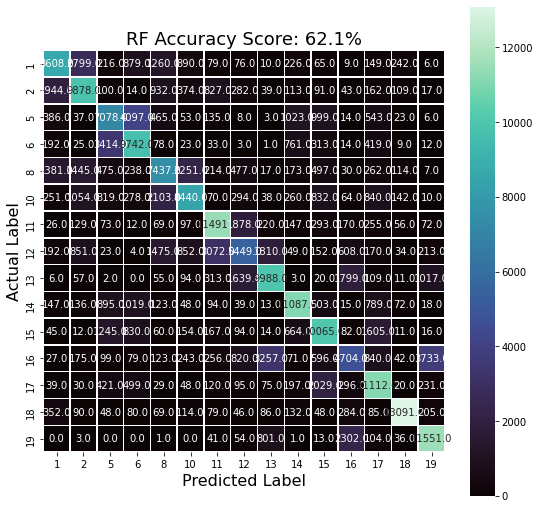

In [21]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = balanced_accuracy_score(y_test, y_prediction)
all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
label = [1,2,5,6,8,10,11,12,13,14,15,16,17,18,19]
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(label)
p.set_yticklabels(label)
p.set_title(all_sample_title, size = 18)

#save
# fig = p.get_figure()
# fig.savefig('/content/drive/MyDrive/james_bay_Cmatrix.png')

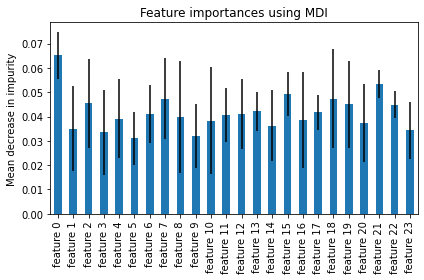

In [22]:
#Find which features were most important
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()